# Техническое задание

Автор: Кузьмин Дмитрий

## Задание

Анализ паттернов плохо распознаваемых EEG-файлов:

* Анализ качества сырых данных
* Анализ распределения признаков
* Анализ баланса классов
* Визуальный анализ EEG
* Анализ предсказаний модели

## Ожидаемые результаты

* Таблица QC-метрик для всех файлов проблемных пациентов
* Таблица баланса классов для всех пациентов
* Графики распределений признаков 
* ROC-кривые для проблемных пацфиентов
* Визуализации EEG — примеры preictal окон

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats 

## Анализ качества сырых данных

Цель: Выявить проблемы с качеством исходных EEG-записей.

In [3]:
problem_patient = ['chb15', 'chb18', 'chb19']

In [4]:
qc_normal_patient = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\analysis\qc_normal_patient.csv')
qc_problem_patient = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\analysis\qc_problem_patient.csv')

In [5]:
qc_normal_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,570.0,570.000000,570.0,570.000000,570.000000
mean,0.0,0.000786,0.0,0.000035,0.001480
std,0.0,0.010886,0.0,0.000017,0.000540
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000024,0.001109
50%,0.0,0.000000,0.0,0.000031,0.001443
75%,0.0,0.000000,0.0,0.000043,0.001743
max,0.0,0.172414,0.0,0.000162,0.003873


In [6]:
qc_normal_patient

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,chb24,chb24_13.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001118
566,chb24,chb24_14.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000028,0.001254
567,chb24,chb24_15.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001312
568,chb24,chb24_17.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000039,0.001504


In [7]:
qc_problem_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,106.0,106.0,106.0,106.000000,106.000000
mean,0.0,0.0,0.0,0.000015,0.001214
std,0.0,0.0,0.0,0.000006,0.000709
min,0.0,0.0,0.0,0.000009,0.000355
25%,0.0,0.0,0.0,0.000012,0.000742
50%,0.0,0.0,0.0,0.000015,0.001007
75%,0.0,0.0,0.0,0.000017,0.001485
max,0.0,0.0,0.0,0.000058,0.005549


In [8]:
qc_normal_patient['group'] = 'Normal'
qc_problem_patient['group'] = 'Problem'

In [9]:
QC_data = pd.concat([qc_normal_patient, qc_problem_patient], ignore_index=True)
QC_data

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb19,chb19_26.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000015,0.001581,Problem
672,chb19,chb19_27.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000022,0.001159,Problem
673,chb19,chb19_28.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,924672,True,0.0,0.0,[],0.0,0.000032,0.002495,Problem
674,chb19,chb19_29.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000027,0.002391,Problem


In [10]:
file_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\file_index.csv')
seizure_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\seizure_index.csv')

In [11]:
seizure_columns = seizure_index.columns.difference(['patient', 'edf_path', 'sampling_rate'])

files_data = pd.merge(
    file_index, 
    seizure_index[seizure_columns], 
    on='edf_file', 
    how='left'
)

files_data = files_data[files_data['num_seizures'] >= 1]

In [12]:
files_data = files_data.drop(['file_end_time', 'file_start_time', 'seizure_id', 'seizures', 'file_exists'], axis=1)

In [13]:
files_data = files_data[['patient', 'edf_file', 'num_seizures', 'start_time', 'end_time', 'onset_sec', 'offset_sec', 'duration_sec', 'sampling_rate', 'channels']]
files_data

,patient,edf_file,num_seizures,start_time,end_time,onset_sec,offset_sec,duration_sec,sampling_rate,channels
2,chb01,chb01_03.edf,1,13:43:04,14:43:04,2996.0,3036.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
3,chb01,chb01_04.edf,1,14:43:12,15:43:12,1467.0,1494.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
14,chb01,chb01_15.edf,1,01:44:44,2:44:44,1732.0,1772.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
15,chb01,chb01_16.edf,1,02:44:51,3:44:51,1015.0,1066.0,51.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
17,chb01,chb01_18.edf,1,04:45:06,5:45:06,1720.0,1810.0,90.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
...,...,...,...,...,...,...,...,...,...,...
728,chb24,chb24_13.edf,1,NaN,NaN,3288.0,3304.0,16.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
729,chb24,chb24_14.edf,1,NaN,NaN,1939.0,1966.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
730,chb24,chb24_15.edf,1,NaN,NaN,3552.0,3569.0,17.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
731,chb24,chb24_17.edf,1,NaN,NaN,3515.0,3581.0,66.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."


In [14]:
data = pd.merge(
    file_index,  
    QC_data[['patient', 'edf_file', 'nan_ratio', 'flat_ratio', 'flat_channels', 
             'clipped_ratio', 'mean_amplitude', 'max_amplitude', 'group']],
    on=['patient','edf_file'],
    how='left'   
)
data = data.drop(['seizures', 'channels', 'file_exists', 'sampling_rate', 'edf_path'], axis=1)

In [15]:
data[(data['num_seizures'] >= 1)]

,patient,edf_file,start_time,end_time,num_seizures,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
2,chb01,chb01_03.edf,13:43:04,14:43:04,1,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,14:43:12,15:43:12,1,0.0,0.0,[],0.0,0.000023,0.001286,Normal
14,chb01,chb01_15.edf,01:44:44,2:44:44,1,0.0,0.0,[],0.0,0.000037,0.000736,Normal
15,chb01,chb01_16.edf,02:44:51,3:44:51,1,0.0,0.0,[],0.0,0.000037,0.001218,Normal
17,chb01,chb01_18.edf,04:45:06,5:45:06,1,0.0,0.0,[],0.0,0.000022,0.001019,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb24,chb24_13.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001118,Normal
672,chb24,chb24_14.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000028,0.001254,Normal
673,chb24,chb24_15.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001312,Normal
674,chb24,chb24_17.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000039,0.001504,Normal


In [16]:
data[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,676.0,676.000000,676.0,676.000000,676.000000
mean,0.0,0.000663,0.0,0.000032,0.001439
std,0.0,0.009998,0.0,0.000017,0.000577
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000021,0.001015
50%,0.0,0.000000,0.0,0.000028,0.001373
75%,0.0,0.000000,0.0,0.000040,0.001719
max,0.0,0.172414,0.0,0.000162,0.005549


In [17]:
data[data['flat_ratio'] >= 0.1]

,patient,edf_file,start_time,end_time,num_seizures,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
343,chb12,chb12_27.edf,16:07:06,17:07:06,6,0.0,0.172414,"[3, 9, 13, 19, 23]",0.0,0.000088,0.003124,Normal
344,chb12,chb12_28.edf,17:07:12,18:07:12,1,0.0,0.137931,"[3, 9, 13, 19]",0.0,0.000090,0.001558,Normal
345,chb12,chb12_29.edf,18:07:19,19:07:43,6,0.0,0.137931,"[3, 9, 13, 19]",0.0,0.000125,0.002300,Normal


In [18]:
data

,patient,edf_file,start_time,end_time,num_seizures,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,11:42:54,12:42:54,0,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,12:42:57,13:42:57,0,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,13:43:04,14:43:04,1,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,14:43:12,15:43:12,1,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,15:43:19,16:43:19,0,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb24,chb24_13.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001118,Normal
672,chb24,chb24_14.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000028,0.001254,Normal
673,chb24,chb24_15.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001312,Normal
674,chb24,chb24_17.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000039,0.001504,Normal


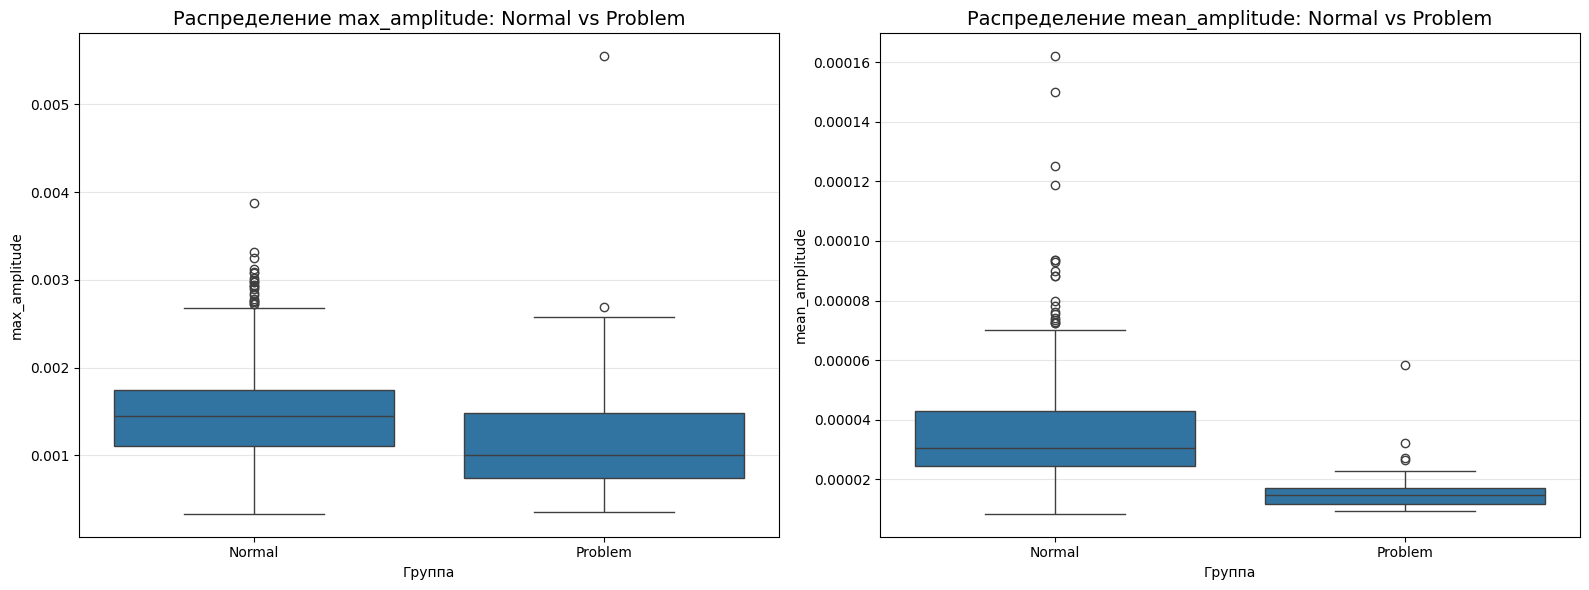

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=data,
    x='group',
    y='max_amplitude',
    ax=axes[0] 
)
axes[0].set_title('Распределение max_amplitude: Normal vs Problem', fontsize=14)
axes[0].set_xlabel('Группа')
axes[0].set_ylabel('max_amplitude')
axes[0].grid(axis='y', alpha=0.3)

sns.boxplot(
    data=data,
    x='group',
    y='mean_amplitude',
    ax=axes[1] 
)
axes[1].set_title('Распределение mean_amplitude: Normal vs Problem', fontsize=14)
axes[1].set_xlabel('Группа')
axes[1].set_ylabel('mean_amplitude')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


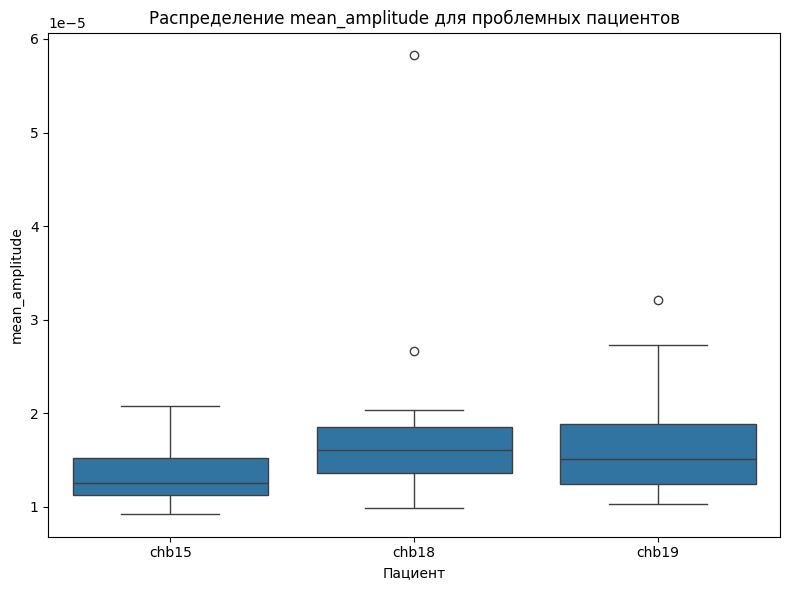

In [20]:
subset = data[data['patient'].isin(problem_patient)]

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=subset,
    x='patient',
    y='mean_amplitude'
)

plt.title('Распределение mean_amplitude для проблемных пациентов')
plt.xlabel('Пациент')
plt.ylabel('mean_amplitude')
plt.tight_layout()
plt.show()

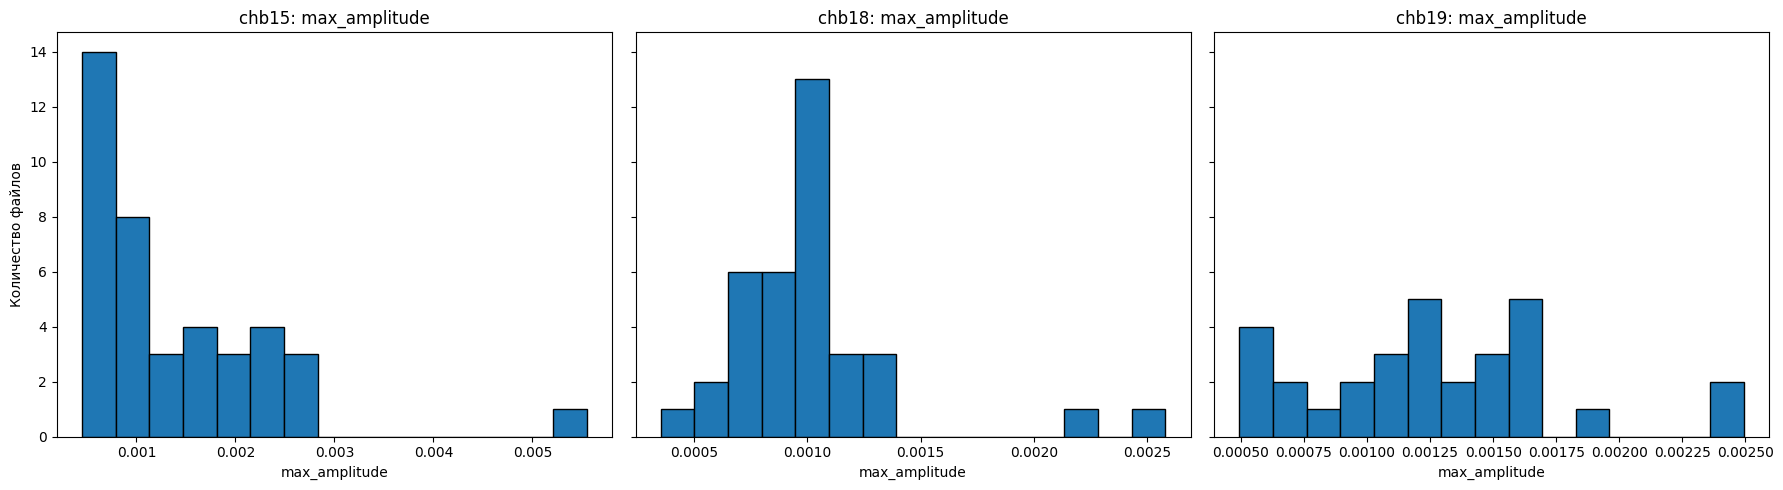

In [21]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, patient in zip(axes, ['chb15', 'chb18', 'chb19']):
    subset = data[data['patient'] == patient]
    ax.hist(subset['max_amplitude'], bins=15, edgecolor='black')
    ax.set_title(f'{patient}: max_amplitude')
    ax.set_xlabel('max_amplitude')
axes[0].set_ylabel('Количество файлов')
plt.tight_layout()
plt.show()

## Анализ распределения признаков

Цель: Сравнить распределения признаков между успешными и проблемными пациентами.

Группы признаков:

*	PSD bands (delta, theta, alpha, beta, gamma) — спектральная мощность
*	Relative power — относительная мощность по диапазонам
*	Statistical (mean, std, skewness, kurtosis) — статистические признаки
*	Hjorth (activity, mobility, complexity) — параметры Хьорта
*	Temporal (line_length, energy) — временные признаки

In [22]:
base_dir = r'C:\Users\_\Desktop\IT\epilepsy\outputs'
meta_cols = ['patient', 'edf_file', 't_start', 't_end', 'label', 'seizure_id']
psd = ['delta', 'theta', 'alpha', 'beta', 'gamma']
stat_features = ['mean', 'std', 'skewness', 'kurtosis', 'line_length', 'energy']
hjorth_features = ['activity', 'mobility', 'complexity']

In [25]:
all_files = []

for patient in os.listdir(base_dir):
    patient_dir = os.path.join(base_dir, patient)
    if not os.path.isdir(patient_dir): 
        continue
    
    for file in os.listdir(patient_dir):
        if file.endswith('_features.csv'):
            csv_path = os.path.join(patient_dir, file)
            features = pd.read_csv(csv_path)
            
            feature_cols = [c for c in features.columns if c not in meta_cols]
            n_features = len(feature_cols)
            n_channels = n_features // 19 
            
            feature_names = []
            for ch in range(n_channels):
                for band in psd:
                    feature_names.append(f'ch{ch}_psd_{band}')
            for ch in range(n_channels):
                for band in psd:
                    feature_names.append(f'ch{ch}_rel_{band}')
            for ch in range(n_channels):
                for stat in stat_features:
                    feature_names.append(f'ch{ch}_{stat}')
            for ch in range(n_channels):
                for hj in hjorth_features:
                    feature_names.append(f'ch{ch}_hjorth_{hj}')
            
            rename_map = {old: new for old, new in zip(feature_cols, feature_names)}
            features_renamed = features.rename(columns=rename_map)
            
            agg_df = pd.DataFrame()
            agg_df[meta_cols] = features_renamed[meta_cols]
            
            for band in psd:
                cols = [c for c in features_renamed.columns if c.endswith(f'psd_{band}')]
                agg_df[f'psd_{band}'] = features_renamed[cols].mean(axis=1)
            
            for band in psd:
                cols = [c for c in features_renamed.columns if c.endswith(f'rel_{band}')]
                agg_df[f'rel_{band}'] = features_renamed[cols].mean(axis=1)
            
            agg_df['line_length'] = features_renamed.filter(regex='line_length$').mean(axis=1)
            agg_df['energy'] = features_renamed.filter(regex='energy$').mean(axis=1)
            agg_df['std'] = features_renamed.filter(regex='_std$').mean(axis=1)
            agg_df['kurtosis'] = features_renamed.filter(regex='kurtosis$').mean(axis=1)
            agg_df['skewness_mean'] = features_renamed.filter(regex='skewness$').mean(axis=1)
            
            for hj in hjorth_features:
                cols = features_renamed.filter(regex=rf'ch\d+_hjorth_{hj}$')
                if not cols.empty:
                    agg_df[f'hjorth_{hj}'] = cols.mean(axis=1)
                else:
                    agg_df[f'hjorth_{hj}'] = pd.NA
            all_files.append(agg_df)

full_dataset = pd.concat(all_files, ignore_index=True)
print(f"Загружено {len(full_dataset)} записей из {len(all_files)} файлов")
full_dataset.head()

Загружено 1504909 записей из 24 файлов


,patient,edf_file,t_start,t_end,label,seizure_id,psd_delta,psd_theta,psd_alpha,psd_beta,...,rel_beta,rel_gamma,line_length,energy,std,kurtosis,skewness_mean,hjorth_activity,hjorth_mobility,hjorth_complexity
0,chb01,chb01_01.edf,0.0,4.0,0,0,1.326521e-10,3.814545e-11,9.941598e-12,6.833621e-12,...,0.109781,0.068197,0.006506,1.433142e-06,0.000034,0.676090,0.057887,1.364183e-09,0.259070,0.712728
1,chb01,chb01_01.edf,2.0,6.0,0,0,4.434615e-11,1.982348e-11,8.016547e-12,1.050168e-11,...,0.222846,0.163120,0.008190,7.117215e-07,0.000025,0.915783,0.301629,6.943277e-10,0.384420,0.523093
2,chb01,chb01_01.edf,4.0,8.0,0,0,2.921967e-10,2.880948e-11,8.768935e-12,7.379027e-12,...,0.109110,0.074025,0.007272,1.449188e-06,0.000033,1.528394,0.030597,1.414556e-09,0.292726,0.876443
3,chb01,chb01_01.edf,6.0,10.0,0,0,5.444688e-10,7.869548e-11,8.952188e-12,4.554142e-12,...,0.072527,0.038713,0.005627,2.286992e-06,0.000039,2.480516,0.619979,2.231427e-09,0.226778,1.058138
4,chb01,chb01_01.edf,8.0,12.0,0,0,5.981187e-10,1.210229e-10,1.722867e-11,1.065086e-11,...,0.092634,0.074458,0.007511,2.993289e-06,0.000046,3.699934,0.421207,2.922604e-09,0.277940,1.348405


In [28]:
full_dataset.isna().sum().sum()

np.int64(75738)

In [32]:
data = pd.merge(full_dataset, data[['patient', 'edf_file', 'group']], on=['patient', 'edf_file'], how='left')

normal_features = data[data['group'] == 'Normal'].copy()
problem_features = data[data['group'] == 'Problem'].copy()

In [34]:

data = pd.concat([normal_features, problem_features], ignore_index=True)
data = data.dropna(subset=['hjorth_activity', 'hjorth_mobility', 'hjorth_complexity'])
data

,patient,edf_file,t_start,t_end,label,seizure_id,psd_delta,psd_theta,psd_alpha,psd_beta,...,rel_gamma,line_length,energy,std,kurtosis,skewness_mean,hjorth_activity,hjorth_mobility,hjorth_complexity,group
0,chb01,chb01_01.edf,0.0,4.0,0,0,1.326521e-10,3.814545e-11,9.941598e-12,6.833621e-12,...,0.068197,0.006506,1.433142e-06,3.412169e-05,0.676090,5.788692e-02,1.364183e-09,0.259070,7.127284e-01,Normal
1,chb01,chb01_01.edf,2.0,6.0,0,0,4.434615e-11,1.982348e-11,8.016547e-12,1.050168e-11,...,0.163120,0.008190,7.117215e-07,2.482526e-05,0.915783,3.016292e-01,6.943277e-10,0.384420,5.230932e-01,Normal
2,chb01,chb01_01.edf,4.0,8.0,0,0,2.921967e-10,2.880948e-11,8.768935e-12,7.379027e-12,...,0.074025,0.007272,1.449188e-06,3.283393e-05,1.528394,3.059736e-02,1.414556e-09,0.292726,8.764434e-01,Normal
3,chb01,chb01_01.edf,6.0,10.0,0,0,5.444688e-10,7.869548e-11,8.952188e-12,4.554142e-12,...,0.038713,0.005627,2.286992e-06,3.925536e-05,2.480516,6.199786e-01,2.231427e-09,0.226778,1.058138e+00,Normal
4,chb01,chb01_01.edf,8.0,12.0,0,0,5.981187e-10,1.210229e-10,1.722867e-11,1.065086e-11,...,0.074458,0.007511,2.993289e-06,4.573531e-05,3.699934,4.212075e-01,2.922604e-09,0.277940,1.348405e+00,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504904,chb19,chb19_30.edf,3086.0,3090.0,1,3,3.668911e-02,6.992261e-03,6.530468e-03,1.642716e-03,...,-0.001154,0.151655,2.797483e-01,5.582275e-07,0.020653,1.106053e-06,1.203419e-01,0.000000,6.339516e-10,Problem
1504905,chb19,chb19_30.edf,3088.0,3092.0,1,3,4.298476e-02,4.172431e-03,2.838617e-03,1.798526e-03,...,0.081595,-0.109302,2.109504e-01,3.922062e-07,0.019613,-8.557208e-07,1.242312e-01,0.000000,4.236294e-10,Problem
1504906,chb19,chb19_30.edf,3090.0,3094.0,1,3,4.028542e-02,1.029901e-02,2.442220e-03,9.046868e-04,...,0.547295,0.776585,4.969344e+00,1.219743e-06,0.017041,1.051920e-06,9.395149e-02,0.000000,1.351169e-09,Problem
1504907,chb19,chb19_30.edf,3092.0,3096.0,1,3,4.389213e-02,1.376101e-02,1.264958e-03,3.647114e-04,...,0.104610,0.141679,6.741123e-01,3.458915e-06,0.012406,2.610260e-06,7.943844e-02,0.000000,3.467922e-09,Problem


### Распределение PSD признаков (спектральная мощность)

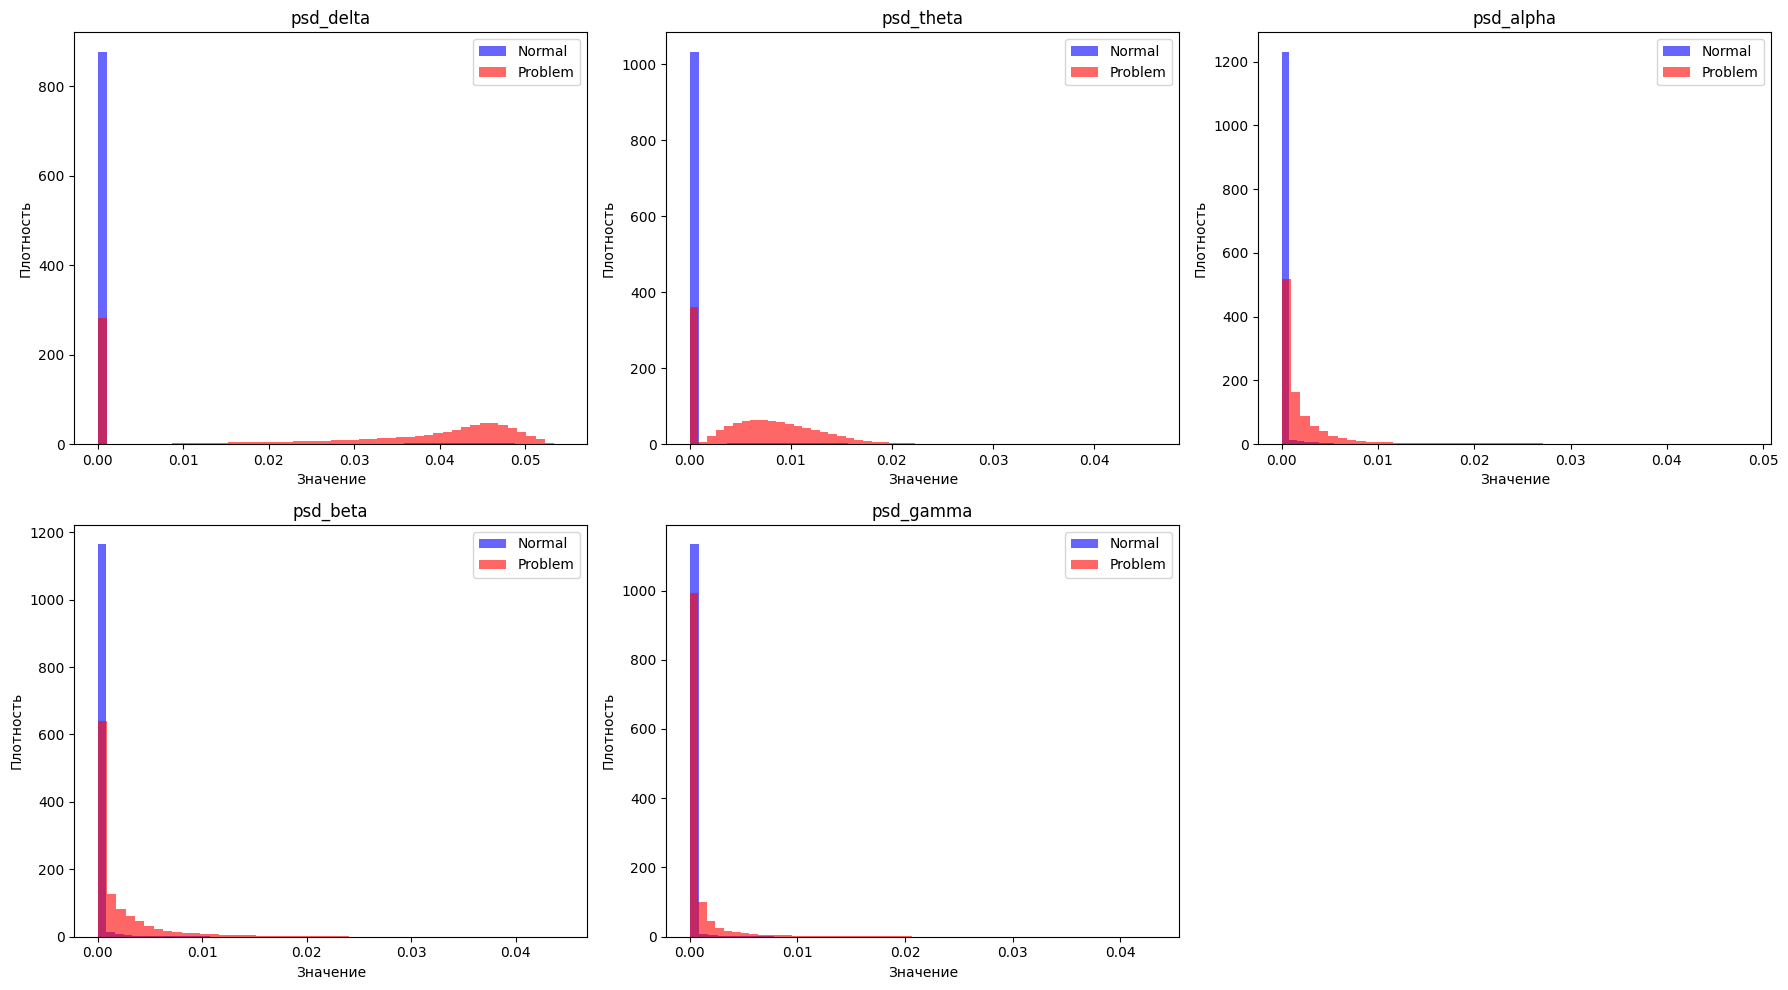

In [42]:
import matplotlib.pyplot as plt

psd_features = ['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma']

plt.figure(figsize=(18, 10))

for i, feature in enumerate(psd_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[data['group']=='Normal'][feature].dropna(), bins=50, alpha=0.6, color='blue', density=True, label='Normal')
    plt.hist(data[data['group']=='Problem'][feature].dropna(), bins=50, alpha=0.6, color='red', density=True, label='Problem')
    plt.title(feature)
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
plt.tight_layout()
plt.show()

### Распределение относительной мощности (Relative Power)

### Распределение признаков Хьорта (Hjorth)

### Сравнение распределений по классам (Interictal vs Preictal) для проблемных пациентов

## Анализ баланса классов

Цель: Проверить корректность разметки и баланс классов.

Метрики: n_files, n_seizure_files, n_windows, n_preictal, n_interictal, ratio

Результат: Таблица баланса классов для всех пациентов 